In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import RBFInterpolator
import os
from pydicom import dcmread
%matplotlib inline

In [20]:
# img_path = os.path.join("Processed",os.listdir("Processed")[0])
img_path = os.path.join("Processed", "I243.dcm")
print(img_path)

Processed\I243.dcm


In [22]:
img = dcmread(img_path)

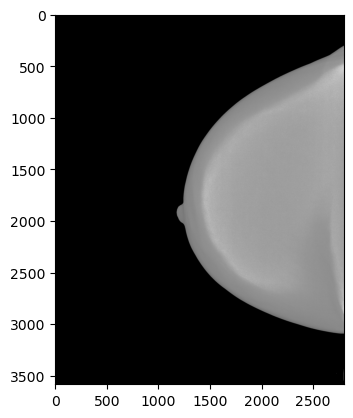

In [26]:
plt.imshow(1-img.pixel_array, cmap='gray')
plt.show()